This code is designed to retrieve surface information from input A-D image files and given instrument response parameters

In [1]:
# Generic imports
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import PIL
import copy
from scipy.interpolate import griddata
from scipy.special import gamma
import scipy.optimize as optimization
import os

# Reloading
from importlib import reload

# Local imports
import sys
sys.path.append('../../../')
import imagestuff as ims
import retrievestuff as rs
import f90nml
import gradstuff as gds
import statstuff as sts

CUDA not available.


In [2]:
%matplotlib notebook

In [3]:
# Specify the file we want to analyze (and output file name)
pwd = os.getcwd()
print(pwd)
startpos = pwd.find('crystals/')
case = pwd[startpos+9:]; print(case)
Segmentnamelistroot = 'Segments1'
imageroot = '20190702_case2.0'
Calibrationfile = '../Case2.0 (calibration)/Calibration.nml'

/Users/nesh/Documents/repositories/ice2020/crystals/2019-07-02/case2.0 (calibration)
2019-07-02/case2.0 (calibration)


In [4]:
# Derivative names
Compressedfilename = Segmentnamelistroot+'_retrieved.npz'; print (Compressedfilename)
Roughnessfile = Segmentnamelistroot+'_roughness.jpg'; print(Roughnessfile)
Roughnessdatafile = Segmentnamelistroot+'_roughness.txt'; print(Roughnessdatafile)

Segments1_retrieved.npz
Segments1_roughness.jpg
Segments1_roughness.txt


In [5]:
# These are derivative names
Segmentnamelist = Segmentnamelistroot+'.nml'
Segmentfile = Segmentnamelist
SEMSegmentjpgfile =  Segmentnamelistroot+'.jpg'
Retrievedjpgfile =   Segmentnamelistroot+'_retrieved.jpg'
Compressedfilename = Segmentnamelistroot+'_retrieved'

In [6]:
# Read the input dataset, including spacing in micrometers
dx,dy,cA,cB,cC,cD,Filename = ims.getc2('', 'SEMimages/', imageroot)
print("Filename, dx and dy", Filename, dx, dy)

SEMimages/20190702_case2.0-A.bmp
SEMimages/20190702_case2.0-B.bmp
SEMimages/20190702_case2.0-C.bmp
SEMimages/20190702_case2.0-D.bmp
Filename, dx and dy SEMimages/20190702_case2.0-D.bmp 0.7632211 0.7632211


In [7]:
# Extract the desired segments
Segments=f90nml.read(Segmentfile) #reads the file at a given path
nysegments=Segments['Segments']['nysegments']
nxsegments=Segments['Segments']['nxsegments']
nacross=Segments['Segments']['nacross']
ndown=Segments['Segments']['ndown']
nxstart=Segments['Segments']['nxstart']
ny1start=Segments['Segments']['ny1start']
ny2start = ny1start+ndown 
nx1list = []; nx2list = []
ny1list = []; ny2list = []
for ix in range(nxsegments):
    nx1start = nxstart+ix*nacross; nx2start = nxstart+(ix+1)*nacross 
    for i in range(nysegments):
        nx1list.append(nx1start); nx2list.append(nx2start)
        ny1list.append(ny1start+i*ndown); ny2list.append(ny2start+i*ndown)
nsegments = nxsegments*nysegments

Benchmark score for random signals = 7.510769209718305
Correlation of detectors A-D for each segment
for segment  0
nx= 41
ny= 41
0 1 0.6829975527673977
0 2 -1.1863612957628207
0 3 -1.9717863493423988
1 2 -0.24181973157988113
1 3 3.0439426298311942
2 3 5.08499628266677
Correlation score = 6.398681965814773



<IPython.core.display.Javascript object>


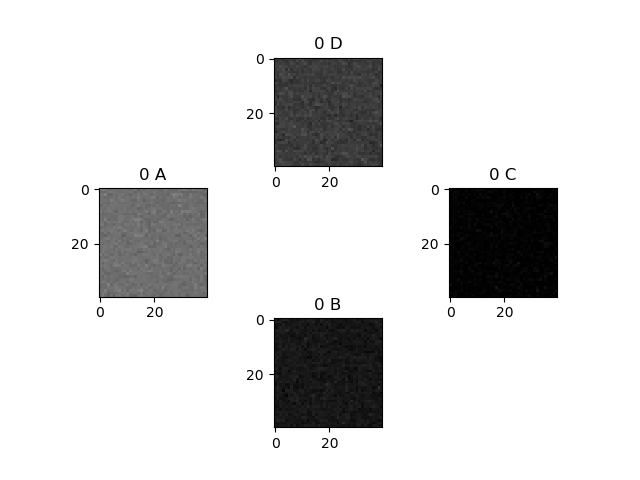

for segment  1
nx= 41
ny= 41
0 1 0.268939125599551
0 2 -0.12587849935983084
0 3 -3.983782447471019
1 2 -2.336365253705212
1 3 0.6442394568007059
2 3 1.6823894433128346
Correlation score = 4.966163262927214



<IPython.core.display.Javascript object>


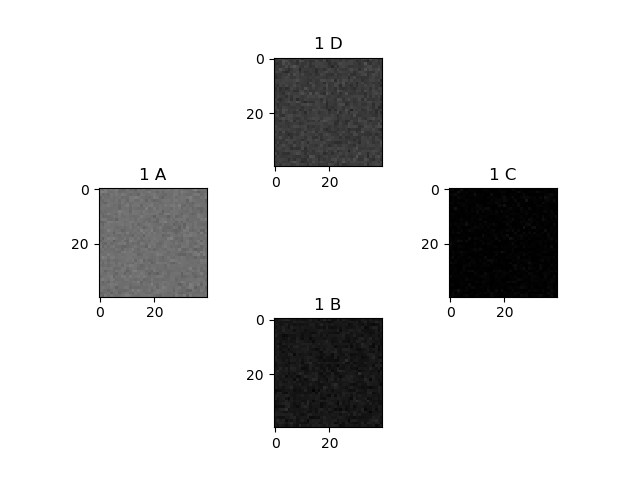

for segment  2
nx= 41
ny= 41
0 1 1.314345316438534
0 2 0.1271486112220036
0 3 1.2168023708723439
1 2 4.490673615595433
1 3 4.895650667957991
2 3 2.0898625055656925
Correlation score = 7.192033694762001



<IPython.core.display.Javascript object>


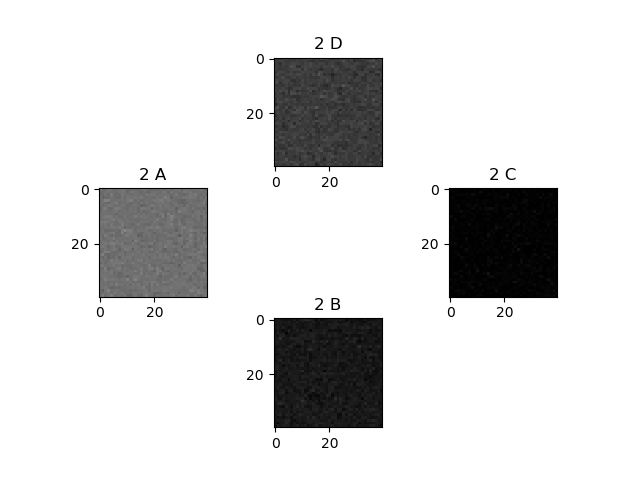

for segment  3
nx= 41
ny= 41
0 1 2.1757485735712585
0 2 0.44435702490624623
0 3 1.3061978606427251
1 2 1.5302594855172131
1 3 0.6767940308165017
2 3 1.0609245633970383
Correlation score = 3.2500450849968185



<IPython.core.display.Javascript object>


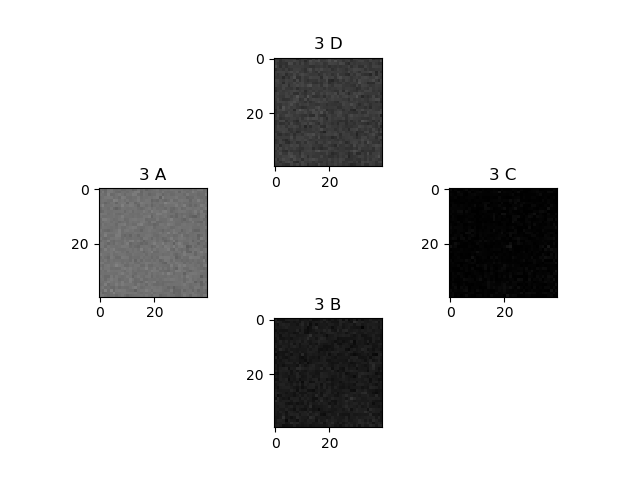

for segment  4
nx= 41
ny= 41
0 1 0.4291800800374541
0 2 3.594063191152924
0 3 -3.12782722036666
1 2 -2.085484824050274
1 3 3.066753655624647
2 3 3.9891325812043092
Correlation score = 7.2492891078798065



<IPython.core.display.Javascript object>


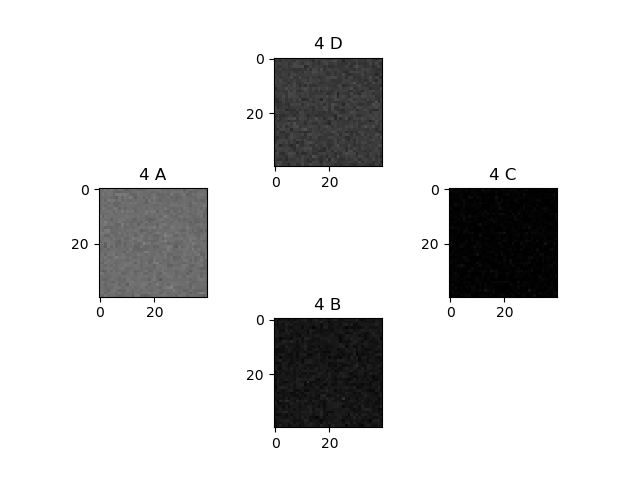

for segment  5
nx= 41
ny= 41
0 1 -1.1513783394627448
0 2 0.665652926157934
0 3 0.5894401495385713
1 2 -1.6517445145174958
1 3 2.0370158165306242
2 3 -0.6234634508648189
Correlation score = 3.0631039226858583



<IPython.core.display.Javascript object>


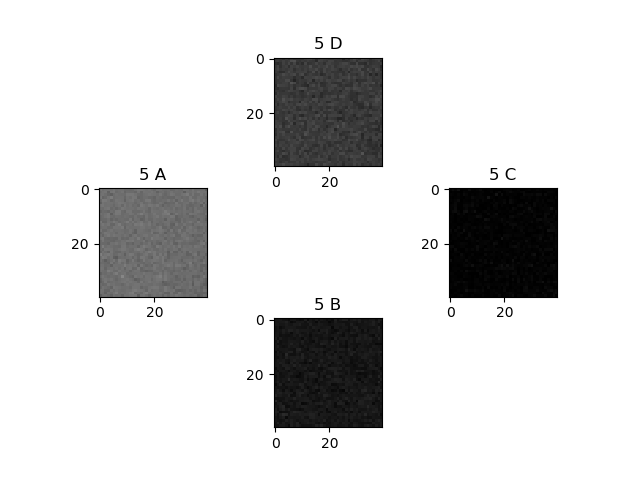

for segment  6
nx= 41
ny= 41
0 1 0.16212499207330433
0 2 -10.031450182745886
0 3 5.431159183991699
1 2 0.4441830719955059
1 3 -8.788262722283669
2 3 -4.196729578516634
Correlation score = 15.006570787370082



<IPython.core.display.Javascript object>


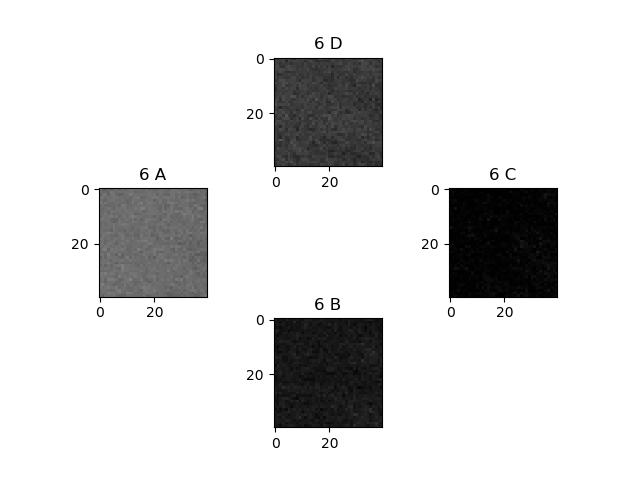

for segment  7
nx= 41
ny= 41
0 1 -8.526025705790616
0 2 -20.381851700033035
0 3 13.781314496447692
1 2 8.549194676027817
1 3 -17.60347828249117
2 3 -6.156954641866758
Correlation score = 33.14991538481971



<IPython.core.display.Javascript object>


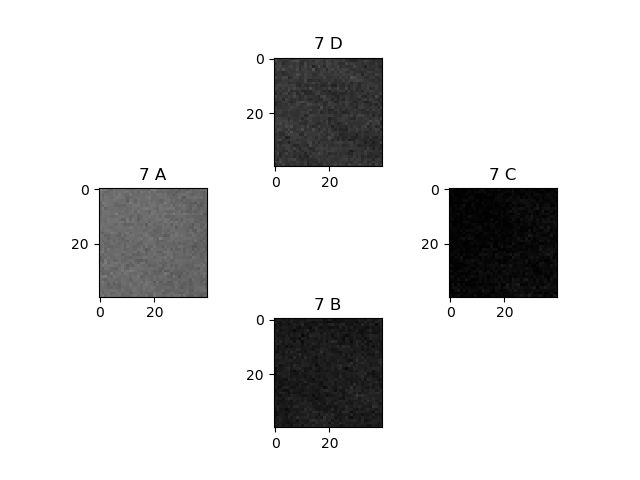

for segment  8
nx= 41
ny= 41
0 1 -0.5576400433786324
0 2 -21.68132101104247
0 3 4.999032917909473
1 2 2.353714097032756
1 3 -3.9455500253863995
2 3 0.6527739804076141
Correlation score = 22.735752071112316



<IPython.core.display.Javascript object>


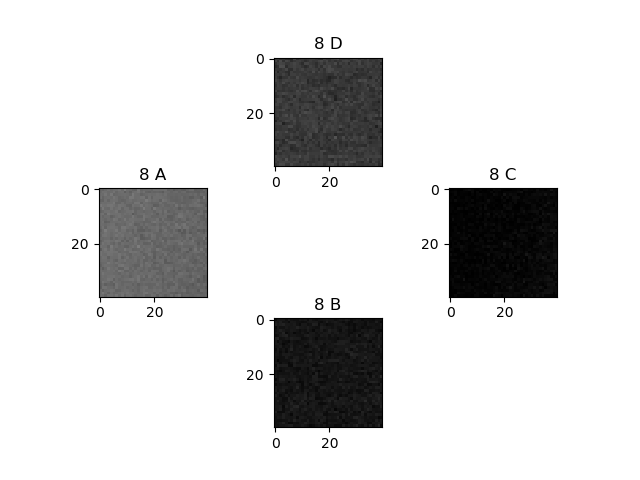

for segment  9
nx= 41
ny= 41
0 1 -4.530877854003038
0 2 -24.36773004502966
0 3 4.551033690255274
1 2 4.248923066305268
1 3 -11.751775850193075
2 3 -2.5337258798576086
Correlation score = 28.24189050003553



<IPython.core.display.Javascript object>


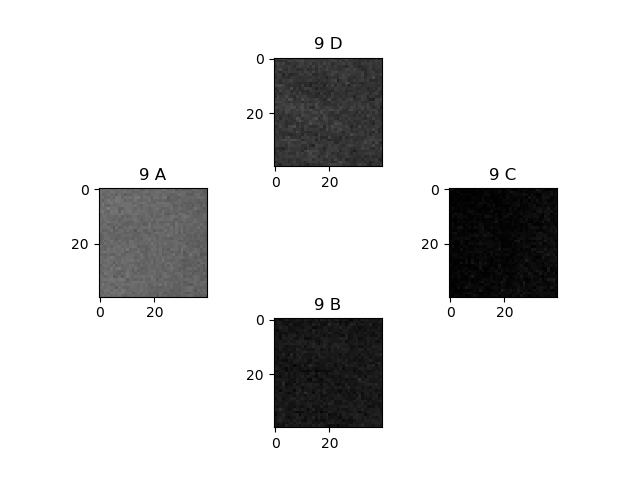

for segment  10
nx= 41
ny= 41
0 1 -0.3701119277194429
0 2 -13.445559347067256
0 3 3.228896364740431
1 2 1.4792764305016992
1 3 -6.6292987954950515
2 3 3.322740381830359
Correlation score = 15.764589612534099



<IPython.core.display.Javascript object>


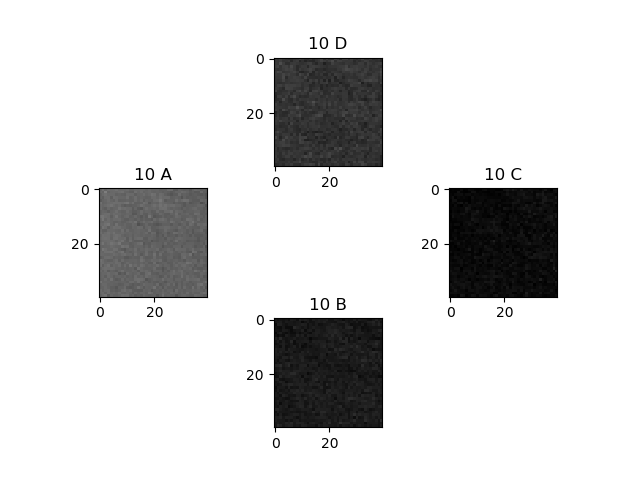

for segment  11
nx= 41
ny= 41
0 1 8.393969032607519
0 2 -2.2613126931728518
0 3 -2.627568606671349
1 2 -2.070840330222723
1 3 -6.821829368818869
2 3 3.558741947210833
Correlation score = 12.0816699117646



<IPython.core.display.Javascript object>


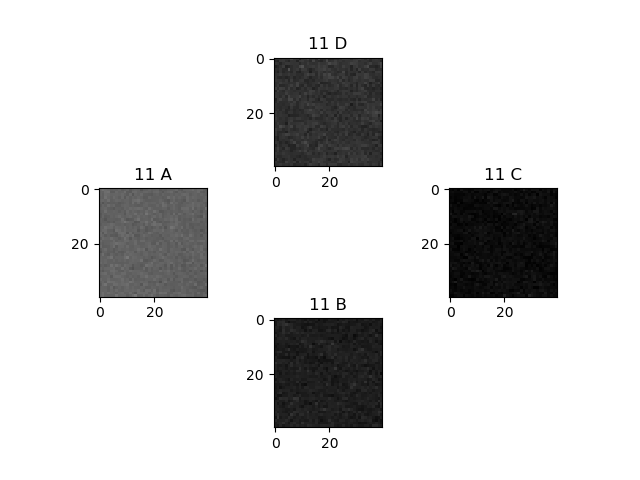

for segment  12
nx= 41
ny= 41
0 1 4.80057889550392
0 2 -10.390618479689024
0 3 2.6931502970216137
1 2 0.6623873501270792
1 3 -5.454443633956894
2 3 0.7796299769929026
Correlation score = 13.002349937738469



<IPython.core.display.Javascript object>


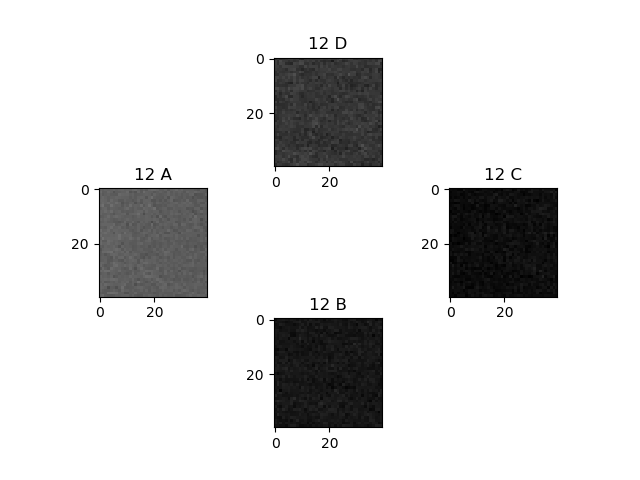

for segment  13
nx= 41
ny= 41
0 1 0.34121361460683075
0 2 -1.8994804328987263
0 3 -2.6343458743319723
1 2 0.3031802741773728
1 3 -7.195881701681811
2 3 1.753599019040351
Correlation score = 8.100121733294923



<IPython.core.display.Javascript object>


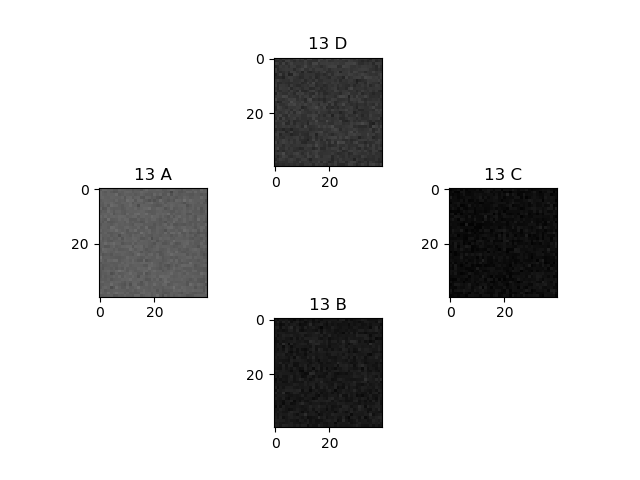

for segment  14
nx= 41
ny= 41
0 1 4.740231632591678
0 2 -7.363200570554501
0 3 -9.61109580626918
1 2 2.561159828374495
1 3 -11.08148348504554
2 3 3.169671212758601
Correlation score = 17.563180596433234



<IPython.core.display.Javascript object>


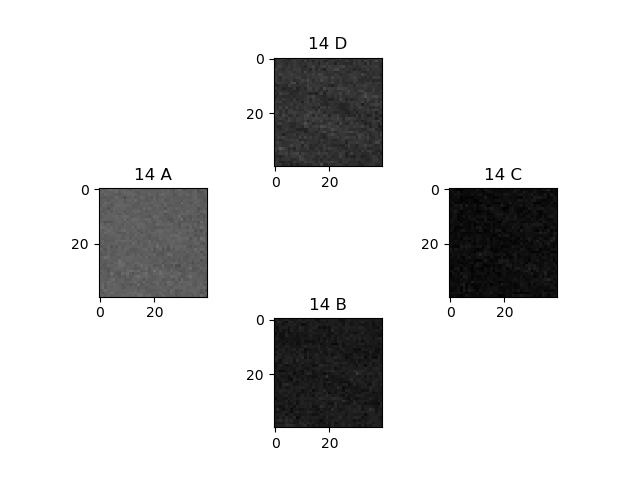

for segment  15
nx= 41
ny= 41
0 1 8.163984817641472
0 2 -3.479915066057078
0 3 2.141456170806906
1 2 -0.6098430429003134
1 3 -6.338506796055037
2 3 11.056811908187171
Correlation score = 15.689103161582496



<IPython.core.display.Javascript object>


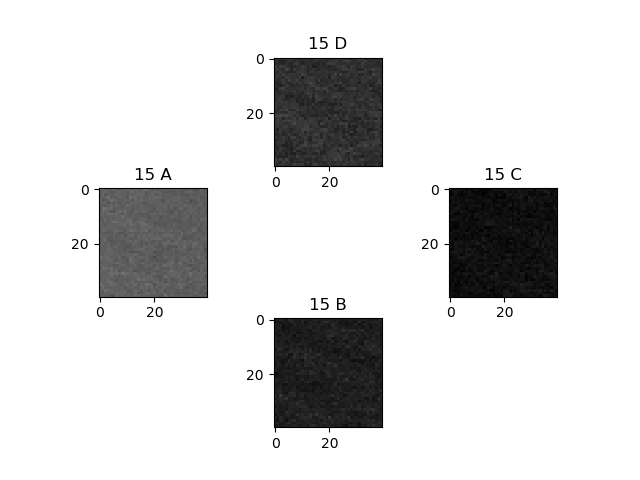

for segment  16
nx= 41
ny= 41
0 1 2.3101975193873874
0 2 -1.9414016121200437
0 3 -2.7246255419273866
1 2 1.0750449462994385
1 3 -7.224073436269192
2 3 0.18362738214422136
Correlation score = 8.360999629619434



<IPython.core.display.Javascript object>


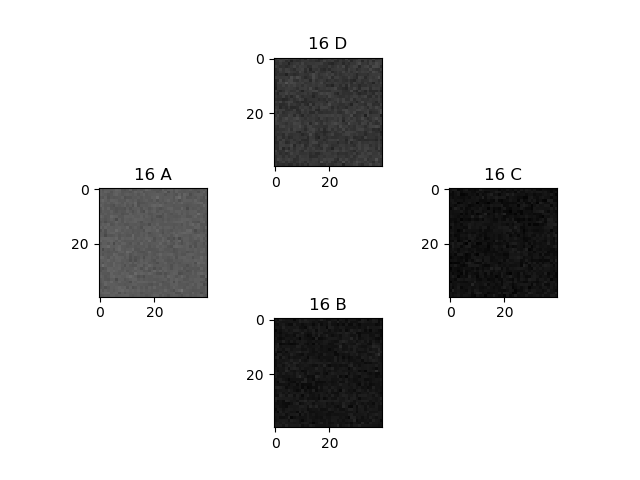

for segment  17
nx= 41
ny= 41
0 1 12.998617702068127
0 2 -0.9844843622860203
0 3 -8.54368666100918
1 2 0.7978354833237177
1 3 -12.061267316304985
2 3 5.209433643730715
Correlation score = 20.400410853898542



<IPython.core.display.Javascript object>


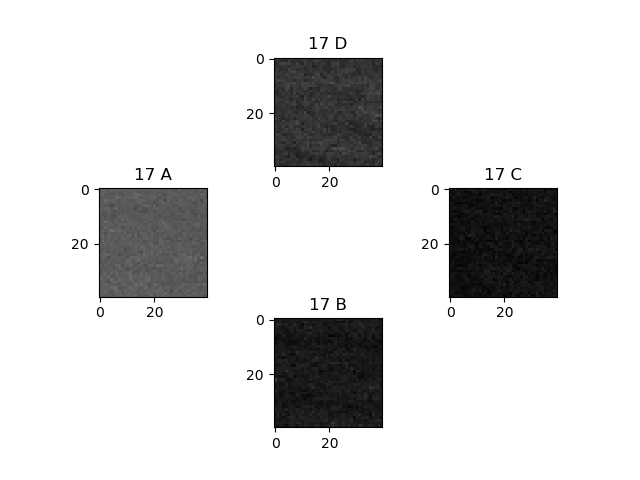

for segment  18
nx= 41
ny= 41
0 1 5.638685208157586
0 2 -4.888906677401197
0 3 -6.746919925873137
1 2 3.0943874647599023
1 3 -19.235149050578286
2 3 4.52544570291047
Correlation score = 22.388902596000413



<IPython.core.display.Javascript object>


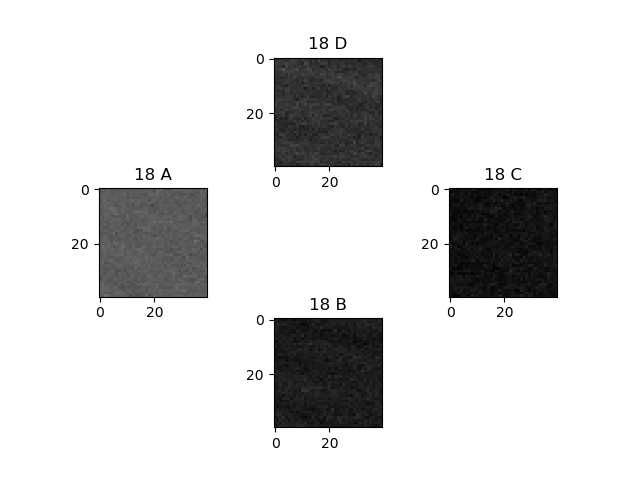

for segment  19
nx= 41
ny= 41
0 1 10.29911478902513
0 2 -0.2998254576674315
0 3 -7.579863249252501
1 2 4.653564627039899
1 3 -9.774162329106508
2 3 6.414301347638666
Correlation score = 17.942941853888712



<IPython.core.display.Javascript object>


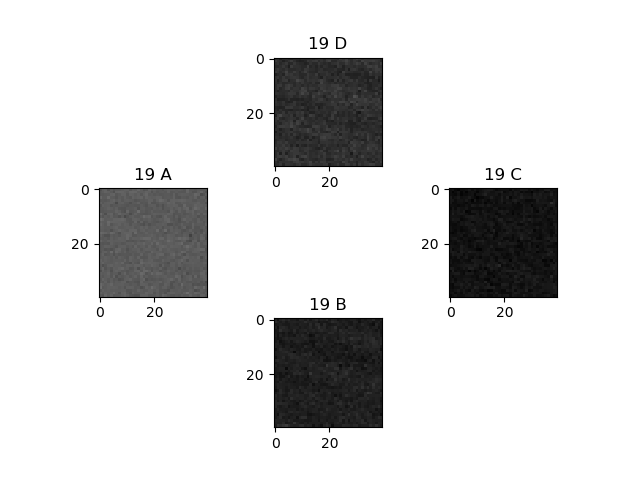

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


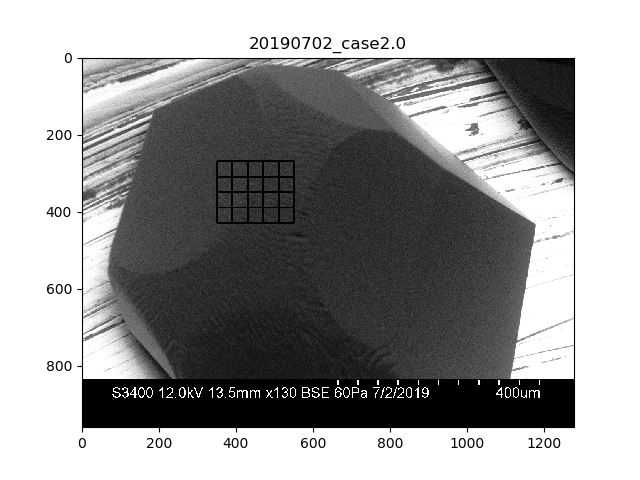

In [8]:
# Display
im = PIL.Image.open(Filename)

# Set up sub-grids in case of multiple segments
nyxgrid = []
for i in range(nsegments):
    nyxgridi = [ (y, x) for y in range(ny1list[i], ny2list[i]+1) for x in range(nx1list[i], nx2list[i]+1) ]
    nyxgrid.append(nyxgridi)

# Add the segments to the image
draw = PIL.ImageDraw.Draw(im)
for i in range(nsegments):
    nx1 = nx1list[i]
    nx2 = nx2list[i]
    ny1 = ny1list[i]
    ny2 = ny2list[i]
    ims.myrectangle(draw,(nx1,ny1),(nx2,ny2),5)

# What's the random expectation of information content
print('Benchmark score for random signals =', sts.randomcorrelation(nacross,ndown)*100*3)
    
# Loop to evaluate the information content in each segment
print('Correlation of detectors A-D for each segment')
for isegment in range(nsegments):
    
    print('for segment ', isegment)
    nx1=nx1list[isegment]; nx2=nx2list[isegment]; nx = nx2-nx1+1; print('nx=',nx)
    ny1=ny1list[isegment]; ny2=ny2list[isegment]; ny = ny2-ny1+1; print('ny=',ny)
    cAseg = cA[ny1:ny2,nx1:nx2]; #cAsegmean = np.mean(cAseg); print('<cA> =',cAsegmean)
    cBseg = cB[ny1:ny2,nx1:nx2]; #cBsegmean = np.mean(cBseg); print('<cB> =',cBsegmean)
    cCseg = cC[ny1:ny2,nx1:nx2]; #cCsegmean = np.mean(cCseg); print('<cC> =',cCsegmean)
    cDseg = cD[ny1:ny2,nx1:nx2]; #cDsegmean = np.mean(cDseg); print('<cD> =',cDsegmean)
    cseg = [cAseg,cBseg,cCseg,cDseg]
    infoscore = sts.getinfoscore(cseg)
    print('Correlation score =', infoscore)
    print('')

    # Show what the detectors see
    plt.figure()
    plt.subplot(334); plt.imshow(np.asarray(cAseg), cmap = 'Greys_r', vmin = 0, vmax = 255); plt.title(str(isegment)+' A')
    plt.subplot(338); plt.imshow(np.asarray(cBseg), cmap = 'Greys_r', vmin = 0, vmax = 255); plt.title(str(isegment)+' B')
    plt.subplot(336); plt.imshow(np.asarray(cCseg), cmap = 'Greys_r', vmin = 0, vmax = 255); plt.title(str(isegment)+' C')
    plt.subplot(332); plt.imshow(np.asarray(cDseg), cmap = 'Greys_r', vmin = 0, vmax = 255); plt.title(str(isegment)+' D')

# Show it
plt.figure()
plt.imshow(np.asarray(im), cmap = 'Greys_r', vmin = 0, vmax = 255)
plt.title(imageroot)

# Save a copy
im.save(SEMSegmentjpgfile)

In [9]:
# Read and unpack the calibration data

# Just echo input data files  
print(Calibrationfile)

# Extract
Calibration=f90nml.read(Calibrationfile) #reads the file at a given path
pA=Calibration['Calibration']['pA']
pB=Calibration['Calibration']['pB']
pC=Calibration['Calibration']['pC']
pD=Calibration['Calibration']['pD']

../Case2.0 (calibration)/Calibration.nml


In [10]:
# Set up a grid of surface normal vectors and the backscatter response on them
nptsx = 103
nptsy = 101
nxmid = int(nptsx/2); #print nxmid
nymid = int(nptsy/2); #print nymid
nmax = 5
nxi = np.linspace(-nmax,nmax,nptsx); dnx = nxi[1]-nxi[0]
nyi = np.linspace(-nmax,nmax,nptsy); dny = nyi[1]-nyi[0]
nxigrid,nyigrid = np.meshgrid(nxi,nyi)
theta = 15*np.pi/180
sA = (-nxigrid*np.sin(theta)+np.cos(theta)-1)/(1+nxigrid**2+nyigrid**2)**.5
sB = (-nyigrid*np.sin(theta)+np.cos(theta)-1)/(1+nxigrid**2+nyigrid**2)**.5
sC = (+nxigrid*np.sin(theta)+np.cos(theta)-1)/(1+nxigrid**2+nyigrid**2)**.5
sD = (+nyigrid*np.sin(theta)+np.cos(theta)-1)/(1+nxigrid**2+nyigrid**2)**.5

# Set up the grids     
BSgridA = np.polyval(pA,sA)
BSgridB = np.polyval(pB,sB)
BSgridC = np.polyval(pC,sC)
BSgridD = np.polyval(pD,sD)

In [11]:
# Generating the response function for each detector
BSgridN = [BSgridA, BSgridB, BSgridC, BSgridD]
BSgridL = ['A', 'B', 'C', 'D']
BSmax = 150 # this for display purposes
nxigrid.shape

(101, 103)

In [12]:
# Set up interpolators for detector responses
Arule, Brule, Crule, Drule, \
KAxrule, KAyrule, KBxrule, KByrule, KCxrule, KCyrule, KDxrule, KDyrule =\
rs.setupdetectorresponse2(BSgridA, BSgridB, BSgridC, BSgridD, nxi, nyi, dnx, dny)

In [13]:
# Create a blank slate
solution = np.zeros(cA.shape)

In [14]:
# Generic retrieval parameters
maxiter = 5
tolerance = 10

In [15]:
# Create the a priori/solution set, and the uncertainty set
    
# Define the variance in the observations (BS units^2)
#noiseamp = 5.0
noiseamp = 25.0
print('Std deviation in input signal is', noiseamp**.5)

# Define parameters determining the variance in the a priori (microns^2)
apriorivar0 = 225.0

print('Std deviation in a priori is', apriorivar0**.5)

# Create the initial a priori variance
apriorivar = np.ones(cA.shape)*apriorivar0

# Create the initial a priori set
aprioriset = np.zeros(cA.shape)

Std deviation in input signal is 5.0
Std deviation in a priori is 15.0


In [33]:
# Loop to retrieve each segment
reload(rs)
for isegment in range(nsegments):
    
    # Choose the particular location of the dataset to analyze
    nx1=nx1list[isegment]; nx2=nx2list[isegment]; nx = nx2-nx1+1
    ny1=ny1list[isegment]; ny2=ny2list[isegment]; ny = ny2-ny1+1

    # Construct gradients
    Ny_unscaled, Nx_unscaled = gds.makeNxNy(ny,nx)
    Ny = Ny_unscaled/dy
    Nx = -Nx_unscaled/dx #fixing x inversion
    
    # Number of observations
    nobs = (nx-1)*(ny-1)*4

    # Number of desired points (heights)
    nzpts = ny*nx-1
    
    # Extract the a priori variance
    vartemp = apriorivar[ny1:ny2+1,nx1:nx2+1]
    #vartemp_long = np.reshape(vartemp,nzpts+1,0) # This appears to have been deprecated
    vartemp_long = vartemp.flatten(order='C')
    Sa = np.diag(vartemp_long[:-1]); #print "apriorivar", shape(Sa)
    
    # Extract the starting z
    settemp = solution[ny1:ny2+1,nx1:nx2+1]
    #settemp_long = np.reshape(settemp,nzpts+1,0)
    settemp_long = settemp.flatten(order='C')
    settemp_longminus1 = settemp_long[:-1]
    z_start = np.matrix(settemp_longminus1).T; #print "aprioriset", shape(z_start)
    z_start = z_start*0.0; #print "aprioriset", shape(z_start)

    # Construct the variance in observation + model
    Se = np.matrix(np.eye(nobs))*noiseamp # Variance in observation + model (c)

    # Do the retrieval
    print('')
    print("Segment:", isegment, '(', isegment+1, "of", nsegments, ')')
    print("for", nx1, ny1)
    z_retrieved = rs.retrievesegment(\
        nx1,ny1,nx2,ny2,cA,cB,cC,cD,\
        Sa,Se,z_start,maxiter,tolerance,\
        Nx,Ny,\
        Arule, Brule, Crule, Drule,\
        KAxrule, KAyrule, \
        KBxrule, KByrule, \
        KCxrule, KCyrule, \
        KDxrule, KDyrule)
    
    if isegment == 0:
        solution[ny1:ny2+1,nx1:nx2+1] = copy.copy(z_retrieved)
    else:
        nextsolution = np.zeros(cA.shape)
        nextsolution[ny1:ny2+1,nx1:nx2+1] = copy.copy(z_retrieved)
        overlap = []
        for i in range(isegment):
            nextoverlap = list( set(nyxgrid[i])&set(nyxgrid[isegment]) )
            overlap = overlap + nextoverlap
            Noverlap = len(overlap); 
        print("Noverlap =", Noverlap)
        diff = 0.0
        for j in range(Noverlap):
            diff += nextsolution[overlap[j]] - solution[overlap[j]]
        diffavg = diff/Noverlap
        z_retrieved -= diffavg
        solution[ny1:ny2+1,nx1:nx2+1] = copy.copy(z_retrieved)


Segment: 0 ( 1 of 20 )
for 350 270
Observed intensities (detector B):
mean, max, min = 20.02375 39.0 4.0
<diff>, std(diff), di2 = 5.7085741026578445 28.122939435149128 205417.59846878497
<diff>, std(diff), di2 = 1.0029391674056232 8.850889139109265 14413.407948010272
<diff>, std(diff), di2 = -0.33707959438946616 5.320474780906498 1000.5874135215195
<diff>, std(diff), di2 = -0.7896598222591399 4.6299321351755 49.360813462802376
<diff>, std(diff), di2 = -0.6856128708535713 4.741266410578885 34.24177060553626

Segment: 1 ( 2 of 20 )
for 350 310
Observed intensities (detector B):
mean, max, min = 20.39625 39.0 4.0
<diff>, std(diff), di2 = 5.768261602657844 28.204094473571914 206387.5222255758
<diff>, std(diff), di2 = 1.110176445948789 8.949442744828097 14650.936772517702
<diff>, std(diff), di2 = -0.22312036442302968 5.443643443106217 1040.7806688275823
<diff>, std(diff), di2 = -0.6762099840162138 4.75799914974339 55.03168300835655
<diff>, std(diff), di2 = -0.5690630013771871 4.86849708309

<diff>, std(diff), di2 = -3.3057870894493915 5.491356221787063 0.6138066191937397
Noverlap = 42

Segment: 17 ( 18 of 20 )
for 510 310
Observed intensities (detector B):
mean, max, min = 21.73625 52.0 3.0
<diff>, std(diff), di2 = 2.9438866026578427 20.162628256330926 97853.17714114206
<diff>, std(diff), di2 = -1.7471218805016622 6.553927123908725 1983.1639075070711
<diff>, std(diff), di2 = -2.437568743305332 5.663771967484657 23.345945464744133
<diff>, std(diff), di2 = -2.4952802956381097 5.624960959149102 0.3390520923165422
Noverlap = 84

Segment: 18 ( 19 of 20 )
for 510 350
Observed intensities (detector B):
mean, max, min = 24.120625 43.0 6.0
<diff>, std(diff), di2 = 3.277949102657843 19.20191874337052 88498.24999045368
<diff>, std(diff), di2 = -1.0878986786842908 6.518700031244006 1640.8143373561575
<diff>, std(diff), di2 = -1.6857737212988866 5.846673063560849 18.719822600422855
<diff>, std(diff), di2 = -1.7336759784727644 5.822368441866918 0.3114624046879829
Noverlap = 84

Segment

200
160


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


<IPython.core.display.Javascript object>


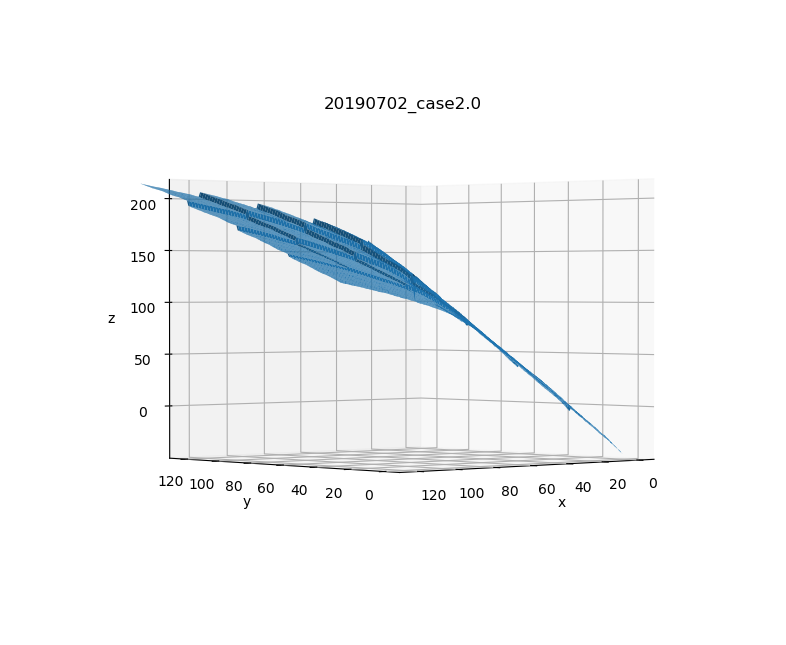

In [34]:
# Show the reconstructed surface
nx1tot = min(nx1list)
nx2tot = max(nx2list)
ny1tot = min(ny1list)
ny2tot = max(ny2list)
nxtot = nx2tot-nx1tot; print (nxtot)
nytot = ny2tot-ny1tot; print (nytot)
ymaxtot = (nytot-1)*dy; xmaxtot = (nxtot-1)*dx

surf_ytot = np.linspace(0,ymaxtot,nytot); #print surf_ytot[1]-surf_ytot[0]; 
surf_xtot = np.linspace(0,xmaxtot,nxtot); #print surf_xtot[1]-surf_xtot[0]; 
surf_xgridtot, surf_ygridtot = np.meshgrid(surf_xtot,surf_ytot)
settemp = solution[ny1tot:ny2tot,nx1tot:nx2tot]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(surf_xgridtot, surf_ygridtot, settemp, rstride=2,cstride=2)
ax.invert_yaxis() # invert y axis (this fixes the right-hand-oriented vs left-hand-oriented system)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title(imageroot)
ax.view_init(azim=-120,elev=22)

In [35]:
# Save this data

#save an image
fig.savefig(Retrievedjpgfile)


print("saving", Compressedfilename)
np.savez_compressed(Compressedfilename, \
                    surfaceroot=imageroot, \
                    imageroot=imageroot, \
                    nx1list=nx1list, \
                    nx2list=nx2list, \
                    ny1list=ny1list, \
                    ny2list=ny2list, \
                    pA=pA, \
                    pB=pB, \
                    pC=pC, \
                    pD=pD, \
                    sA=sA, \
                    sB=sB, \
                    sC=sC, \
                    sD=sD, \
                    nxi=nxi, \
                    nyi=nyi, \
                    dnx=dnx, \
                    dny=dny, \
                    solution=solution)

saving Segments1_retrieved
